---
title: "Logistic Regression with a Neural Network Mindset"
author: "Daniel Smith"
date: "2024-01-16"
categories: [Python, Machine Learning]
title-block-banner: false
jupyter: python3
---

Logistic regression is implemented in NumPy and interpreted as a Perceptron. We use the resulting model to identify cats in an image classification problem, and experiment with tuning the learning rate of gradient descent.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from PIL import Image

%matplotlib inline

- [1 - DATA](#1)
- [2 - THE SIGMOID](#2)
- [3 - LOGISTIC REGRESSION AND GRADIENT DESCENT](#3)
    - [3.1 - Mathematical expression of the algorithm](#3-1)
    - [3.2 - Vectorization](#3-2)
    - [3.3- Gradient Descent](#4-3)
- [4 - FUNCTIONS](#4)
- [5 - THE MODEL](#5)
    - [5.1 - Errors and learning curves](#5.1)
- [6 - ANIMAL TESTING](#6)
- [7 - EXPERIMENTING WITH LEARNING RATES](#7)

<a name='1'></a>

# 1 - DATA

The data comprises of training and test sets of 64x64 images, some of cats and some of not-cats. Each image is encoded as a NumPy array of shape (64,64,3), where the third dimension encapsulates the 3 RGB colour channels of the image. 

The problem is then to contruct and train a model that can accurately classify an unseen image as either a cat ($y=1$) or a non-cat ($y=0$).

In [3]:
train_dataset = h5py.File('train_catvnoncat.h5', "r")
train_set_x_orig = np.array(train_dataset["train_set_x"][:])
train_set_y = np.array(train_dataset["train_set_y"][:])
train_set_y = train_set_y.reshape((1, train_set_y.shape[0]))

In [4]:
test_dataset = h5py.File('test_catvnoncat.h5', "r")
test_set_x_orig = np.array(test_dataset["test_set_x"][:])
test_set_y = np.array(test_dataset["test_set_y"][:])
test_set_y = test_set_y.reshape((1, test_set_y.shape[0]))
classes = np.array(test_dataset["list_classes"][:])

In [5]:
train_set_y.shape

(1, 209)

So our training set comprises of 209 images

In [6]:
test_set_y.shape

(1, 50)

And our test set comprises of another 50 images

y = [1], it's a 'cat' picture.


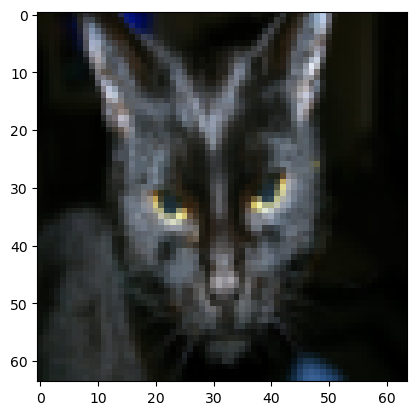

In [7]:
# Example of a 'cat' image
index = 25
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

y = [0], it's a 'non-cat' picture.


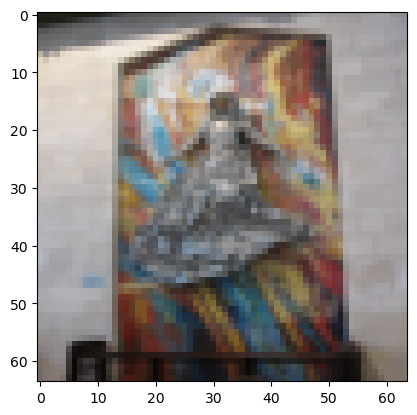

In [8]:
# Example of a 'not-cat' image
index = 86
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

y = [0], it's a 'non-cat' picture.


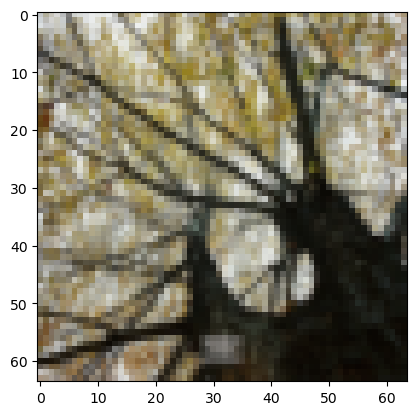

In [9]:
# A random picture from the training set
index = np.random.randint(209)
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [10]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [11]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


In [12]:
# Standardizing the feature data
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

<a name='2'></a>

# 2- THE SIGMOID

The [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) $\sigma$ is defined as

$$\sigma: \mathbb{R} \to \left(0,1\right)$$

\begin{align*}
\sigma(x) &:= \frac{1}{1 + e^{-x}}\\[0.1cm]
          &= \frac{e^{x}}{1+e^{x}}
\end{align*}

$\sigma$ is non-linear, smooth and strictly increasing. It is the activation function of choice for the output layer of Neural Networks applied to binary classification problems. \
In particular, logistic regression uses the sigmoid to extract a prediction of the label for a given feature vector (after composing with a threshold).

In [13]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    return 1/(1+np.exp(-z))

This implementation of the sigmoid, using `numpy.exp` instead of `math.exp`, allows it to be applied to a NumPy array element-wise. This will turn out to be important when implementing logistic regression. \
For example, we can use this property to plot a graph of $\sigma$ on $\mathbb{R}$.

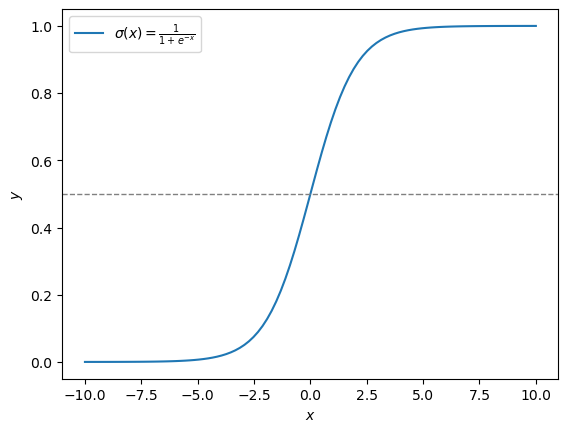

In [14]:
x_values = np.linspace(-10,10,100)
y_values = sigmoid(x_values) # Applying the sigmoid to each element of the x_values array
plt.plot(x_values,y_values,label=r'$\sigma (x) = \frac{1}{1 + e^{-x}}$')

plt.axhline(0.5, color='gray', linestyle='--', linewidth=1)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()

<a name='3'></a>

# 3 - LOGISTIC REGRESSION AND GRADIENT DESCENT

The following image illustrates how the algorithm of [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) may be viewed as as a single [perceptron](https://en.wikipedia.org/wiki/Perceptron) with sigmoid activation.

<img src="percep.png" style="width:650px;height:400px;">

<a name='3.1'></a>

## 3.1 - Mathematical expression of the algorithm

For one training example $\left(x^{(i)},y^{(i)}\right)$ in the training set $\left\{ \left(x^{(i)} , y^{(i)} \right) \right\} _{i=1}^{m}$ and a choice of parameters $w\in\mathbb{R}^{n}$, $b\in\mathbb{R}$

$$z^{(i)} = w^T x^{(i)} + b$$

$$\hat{y}^{(i)} = a^{(i)} = \sigma\left(z^{(i)}\right)$$ 

where $\sigma: \mathbb{R} \to \left(0,1\right)$ is the sigmoid defined above, $n$ is the number of features and $m = m_{\text{train}}$ is the number of training examples.

The prediction $\hat{y}^{(i)}\in \left(0,1\right)$ is interpreted as the probability that $x^{(i)}$ is in class 1 (i.e. is an image of a cat) given the parameters $w$, $b$

$$\hat{y}^{(i)} = \mathbb{P}\left( y^{(i)}=1 \,|\, x^{(i)} \,; \,w, b \right)$$

We can extract a binary prediction in $\{0,1\} \simeq \{\text{non-cat},\text{cat}\}$ from the prediction $\hat{y}^{(i)}$ by applying a threshold
$$y^{(i)}_{\text{pred}} = \mathbb{1} {\left\{a^{(i)} > 0.5\right\}} = \begin{cases}
      1 & \text{if}\ a^{(i)} > 0.5 \\
      0 & \text{otherwise}
    \end{cases}
$$  

Such a threshold can be implemented in code using, for example, `numpy.round`.

We use the [binary cross entropy](https://en.wikipedia.org/wiki/Cross-entropy#Cross-entropy_loss_function_and_logistic_regression) loss function $\mathcal{L}$, defined as

\begin{align*}
\mathcal{L}\left(a^{(i)}, y^{(i)}\right) &=  - y^{(i)}  \log\left(a^{(i)}\right) - \left(1-y^{(i)} \right)  \log\left(1-a^{(i)}\right)\\[0.2cm]
&= \begin{cases} 
- \log\left(a^{(i)}\right) & \text{if } y^{(i)} = 1 \\
- \log\left(1 - a^{(i)}\right) & \text{if } y^{(i)} = 0 
\end{cases}
\end{align*}

The cost $J$ is then computed by summing over all training examples:

\begin{align*}
J &= \frac{1}{m} \sum_{i=1}^{m} \mathcal{L}\left(a^{(i)}, y^{(i)}\right)\\[0.2cm]
  &= \frac{-1}{m} \sum_{i=1}^{m} \left[ y^{(i)}  \log\left(a^{(i)}\right) + \left(1-y^{(i)} \right)  \log\left(1-a^{(i)}\right) \right]
\end{align*}

<a name='3.2'></a>

## 3.2 - Vectorization

Looping over all the $m$ training examples $\left (x^{(i)},y^{(i)} \right)$ in turn to calculate $\hat{y}^{(i)} = a^{(i)} = \sigma\left(z^{(i)}\right) = \sigma\left( w^T x^{(i)} + b\right)$ and $\mathcal{L}\left(a^{(i)}, y^{(i)}\right)$ is computationally inefficient if $m$ is large $\left(\text{e.g.}\,\, m\sim10^6\right)$ as is common in modern industry applications.


By turning to a so called *Vectorized* implementation we can take advantage of NumPy's powerful numerical linear algebra capabilities.
Define vectors $Z = \left( z^{(1)}, z^{(2)}, \dots, z^{(m)} \right) \in \mathbb{R}^m$ and $A = \left( a^{(1)}, a^{(2)}, \dots, a^{(m)} \right) \in \mathbb{R}^m$. Define the $n\,\times\,m$ matrix $X$ with $i^{\text{th}}$ column $x^{(i)}$. That is,

\begin{equation}
X = \begin{bmatrix}
    | & | & \cdots & | \\
    x^{(1)} & x^{(2)} & \cdots & x^{(m)} \\
    | & | & \cdots & |
\end{bmatrix}\in \mathcal{M}_{n,m} \left(\mathbb{R}\right)
\end{equation}

Then

\begin{align*}
w^T X + \left(b,b,\dots,b\right) &= \left( w^T x^{(1)}+b, \,w^T x^{(2)}+b, \dots ,\,w^T x^{(n)}+b \right)\\[0.2cm]
                                 &= \left( z^{(1)}, z^{(2)}, \dots, z^{(m)} \right)\\[0.2cm]
                                 &= Z
\end{align*}

So if $\mathbf{b} = \left(b,b,\dots,b\right)$ then $Z = w^T X + \mathbf{b}$. We can implement this in code as `Z = np.dot(w.T,X) + b` where we have taken advantage of [python broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html) to add the scalar `b` to the array `np.dot(w.T,X)`. NumPy then interprets this addition as element-wise. We then have $A = \left( a^{(1)}, a^{(2)}, \dots, a^{(m)} \right) = \sigma (Z)$ since the sigmoid $\sigma$ acts on arrays element-wise.

<a name='3.3'></a>

## 3.3 - Gradient Descent
The optimization problem
$$
\min_{w,b} J(w, b)
$$

is numerically solved through application of [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent). For our purposes, gradient descent comprises of recursively updating $b$ and the components $w_j$ of $w$ according to 

\begin{align*}
w_j &\rightarrow w_j - \alpha \frac{\partial J}{\partial w_j}\\[0.1cm]
b &\rightarrow b - \alpha \frac{\partial J}{\partial b}
\end{align*}

where $\alpha << 1$ is a fixed hyperparameter called the *learning rate*. Another free hyperparameter introduced with gradient descent is the number of iterations to repeat this updating process.

<a name='4'></a>

# 4 - FUNCTIONS

Defining some functions needed to construct the logistic regression model

In [15]:
def initialize_with_zeros(dim):
    """
    Create a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias) of type float
    """
    w = np.zeros((dim,1))
    b = float(0)
    
    return w, b

In [16]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    grads -- dictionary containing the gradients of the weights and bias
            (dw -- gradient of the loss with respect to w, thus same shape as w)
            (db -- gradient of the loss with respect to b, thus same shape as b)
    cost -- negative log-likelihood cost for logistic regression
    """
    
    m = X.shape[1]
    
    A = sigmoid(np.dot(w.T,X)+b)
    cost = (-1/m) * (np.dot(Y, np.log(A).T) + np.dot((1 - Y), np.log(1 - A).T))

    dw = (1/m)*np.dot(X,(A-Y).T)
    db = (1/m)*np.sum(A-Y)
    
    cost = np.squeeze(np.array(cost))
  
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [17]:
def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    """
    Optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        grads, cost = propagate(w,b,X,Y)
        
        dw = grads["dw"]
        db = grads["db"]
        
        w = w - learning_rate*dw
        b = b - learning_rate*db
 
        if i % 100 == 0:
            costs.append(cost)
        
            # Print the cost every 100 training iterations
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [18]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    
    w = w.reshape(X.shape[0], 1)

    A = sigmoid(np.dot(w.T,X)+b) 

    for i in range(A.shape[1]):        
        Y_prediction[0,i] = np.round(A[0,i])
    
    return Y_prediction

<a name='5'></a>

# 5 - THE MODEL
Combining the previously defined functions `intialize_with_zeros`, `propagate`, `optimize` and `predict` into the logistic regression model

In [19]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Combines the helper functions to construct the model
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to True to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    w, b = initialize_with_zeros(X_train.shape[0])
    
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost=False)
    
    w = params['w']
    b = params['b']
    
    Y_prediction_test = predict(w,b,X_test)
    Y_prediction_train = predict(w,b,X_train)

    # Print train/test Errors
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [20]:
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)

train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


The model accuractely classified >99% of the images in the training set and 70% of the images in the test set, suggesting that we are experiences overfitting to our training data. \
This could be counteracted in several ways, such as including an $L_2$ regularization term in the expression for the cost function $J$. We won't explore such possibilities in this post.

<a name='5.1'></a>

## 5.1 - Errors and learning curves

y = 1, predicted as "non-cat" picture.


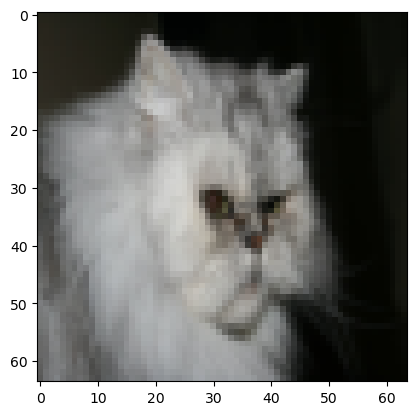

In [21]:
# Example of a 'cat' that was inaccuractely classified as 'not-cat' (False Negative)
index = 10
plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", predicted as \"" + classes[int(logistic_regression_model['Y_prediction_test'][0,index])].decode("utf-8") +  "\" picture.")

y = 0, predicted as "cat" picture.


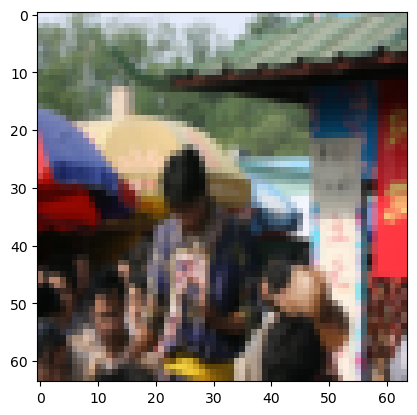

In [54]:
# Example of a 'not-cat' that was inaccuractely classified as 'cat' (False Positive)
index = 34
plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", predicted as \"" + classes[int(logistic_regression_model['Y_prediction_test'][0,index])].decode("utf-8") +  "\" picture.")

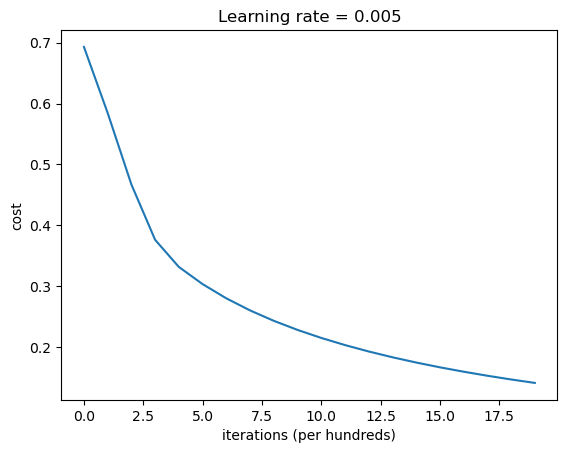

In [23]:
# Plot learning curve (with costs)
costs = np.squeeze(logistic_regression_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate = " + str(logistic_regression_model["learning_rate"]))
plt.show()

<a name='6'></a>

# 6 - ANIMAL TESTING

In [58]:
def is_cat(image_str):
    '''
    Applies the trained logistic regression model to predict if an inputted image is a cat (y=1) or a non-cat (y=0)
    
    Arguments:
    image_str - a string encoding the file name of the .jpg file, 
                e.g. 'cat.jpg' if cat.jpg is the file name of an image saved in the same directory as this notebook.
    Returns:
    None
    '''
    # Read the original image
    original_image = np.array(Image.open(image_str))
    
    # Show the original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    
    # Resize the image to 64x64
    resized_image = np.array(Image.open(image_str).resize((num_px, num_px)))
    
    # Show the resized image
    plt.subplot(1, 2, 2)
    plt.imshow(resized_image)
    plt.title("Resized Image (64x64)")
    
    # Standardize and flatten the resized image 
    image = resized_image / 255.
    image = image.reshape((1, num_px * num_px * 3)).T
    
    # Predict label using training logistic regression model
    my_predicted_image = predict(logistic_regression_model["w"], logistic_regression_model["b"], image)
    
    # Print the prediction for the resized image
    print("y = " + str(int(np.squeeze(my_predicted_image))) + ", the model predicts this is a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

Let's test the function `is_cat` on an image of my own cat, William. \
He's middle-aged and overweight.

y = 0, the model predicts this is a "non-cat" picture.


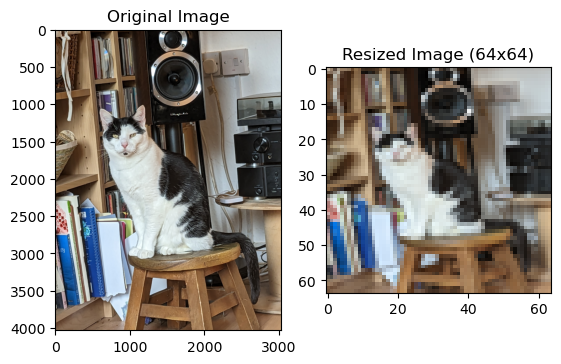

In [49]:
is_cat('william.jpg')

Unsuprising. He's always been a disappointment.\
Observing on some other images in my camera roll:

y = 1, the model predicts this is a "cat" picture.


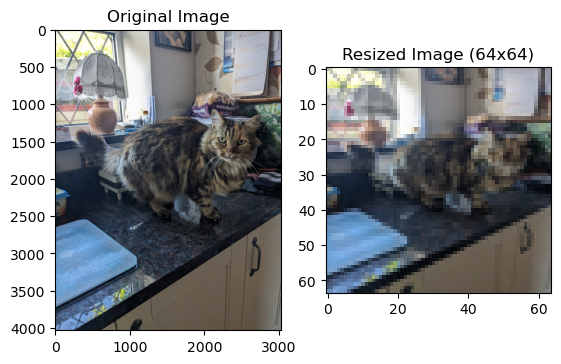

In [55]:
is_cat('flora.jpg')

y = 0, the model predicts this is a "non-cat" picture.


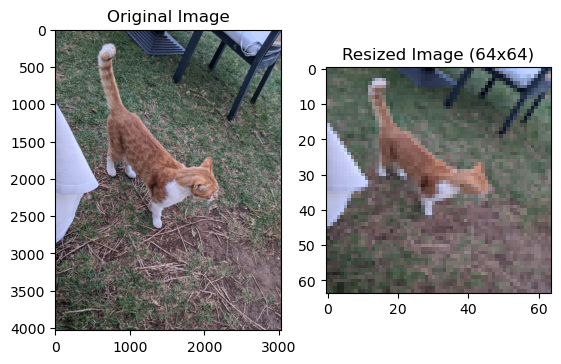

In [56]:
is_cat('ginger_greek_cat.jpg')

y = 1, the model predicts this is a "cat" picture.


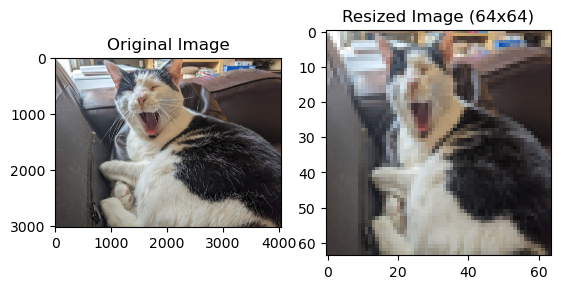

In [57]:
is_cat('william_yawning.jpg')

y = 1, the model predicts this is a "cat" picture.


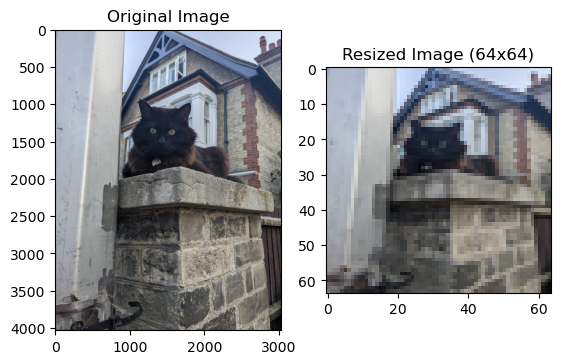

In [59]:
is_cat('cambridge_cat.jpg')

y = 0, the model predicts this is a "non-cat" picture.


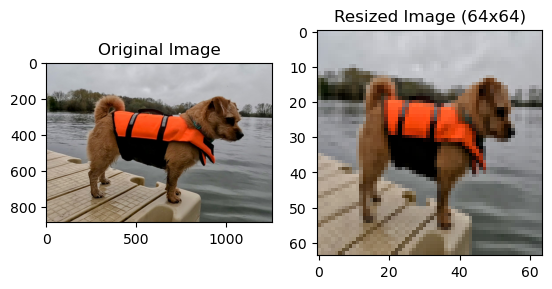

In [60]:
is_cat('lexi.jpg')

y = 1, the model predicts this is a "cat" picture.


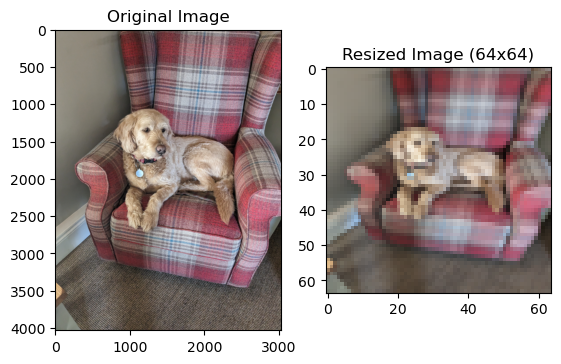

In [61]:
is_cat('toby.jpg')

Oh dear. Time to do some tuning.

<a name='7'></a>

# 7 - EXPERIMENTING WITH LEARNING RATES

In [43]:
def experiment_with_lr(learning_rates,num_iter):
    '''
    Trains a model with a choice of different learning rates with num_iterations=num_iter, printing the train/test accuracy and plotting the resulting learning curves.
    
    Arguments:
    learning_rates - a list of learning rates (a list of floats between 0 and 1)
    num_iter - hyperparameter representing the number of iterations to optimize the parameters (integer)
    
    Returns:
    None
    '''
    for lr in learning_rates:
        print ("Training a model with learning rate: " + str(lr))
        models[str(lr)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=num_iter, learning_rate=lr, print_cost=True)
        print ('\n' + "-------------------------------------------------------" + '\n')

    for lr in learning_rates:
        plt.plot(np.squeeze(models[str(lr)]["costs"]), label=str(models[str(lr)]["learning_rate"]))

    plt.ylabel('Cost')
    plt.xlabel('Iterations (hundreds)')

    legend = plt.legend(loc='upper center', shadow=True)
    frame = legend.get_frame()
    frame.set_facecolor('0.90')

Training a model with learning rate: 0.01
train accuracy: 100.0 %
test accuracy: 68.0 %

-------------------------------------------------------

Training a model with learning rate: 0.001
train accuracy: 93.77990430622009 %
test accuracy: 74.0 %

-------------------------------------------------------

Training a model with learning rate: 0.0001
train accuracy: 73.6842105263158 %
test accuracy: 50.0 %

-------------------------------------------------------



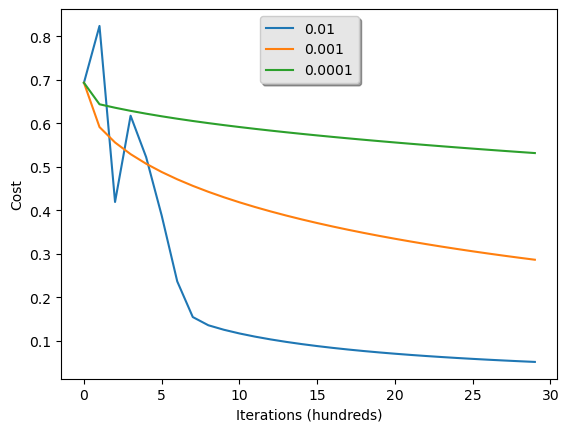

In [44]:
learning_rates = [0.01, 0.001, 0.0001]
experiment_with_lr(learning_rates,num_iter=3000)

The model performed significantly better with the highest learning rate of 0.01

Training a model with learning rate: 0.005
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

Training a model with learning rate: 0.01
train accuracy: 100.0 %
test accuracy: 68.0 %

-------------------------------------------------------

Training a model with learning rate: 0.015
train accuracy: 100.0 %
test accuracy: 68.0 %

-------------------------------------------------------



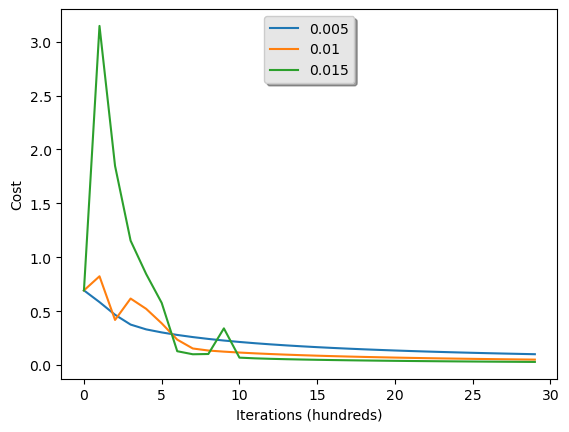

In [46]:
learning_rates = [0.005, 0.01, 0.015]
experiment_with_lr(learning_rates,num_iter=3000)

Training a model with learning rate: 0.01
train accuracy: 100.0 %
test accuracy: 68.0 %

-------------------------------------------------------

Training a model with learning rate: 0.0125
train accuracy: 100.0 %
test accuracy: 68.0 %

-------------------------------------------------------

Training a model with learning rate: 0.015
train accuracy: 100.0 %
test accuracy: 68.0 %

-------------------------------------------------------

Training a model with learning rate: 0.0175
train accuracy: 100.0 %
test accuracy: 68.0 %

-------------------------------------------------------

Training a model with learning rate: 0.02
train accuracy: 100.0 %
test accuracy: 68.0 %

-------------------------------------------------------



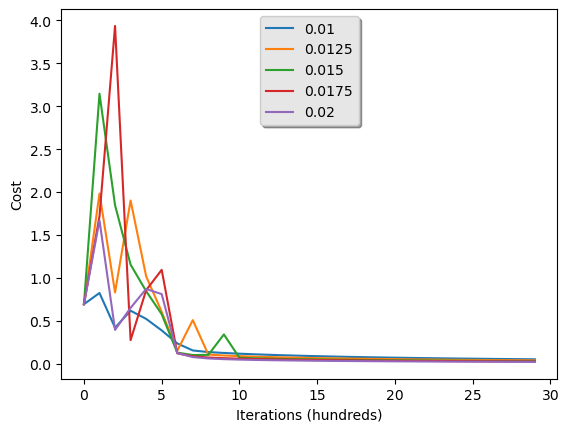

In [47]:
learning_rates = [0.01, 0.0125, 0.015, 0.0175, 0.02]
experiment_with_lr(learning_rates,num_iter=3000)

Tuning the learning rate at such a fine resolution doesn't appear to make a difference to the final performance on the test set.